# Imputing data using KNN imputer

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
# read the data

df = pd.read_csv('data/df_imputing.csv')

In [4]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,33590.0,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al
1,22590.0,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al
2,39590.0,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al
3,30990.0,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al
4,15000.0,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258940 entries, 0 to 258939
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         258940 non-null  float64
 1   year          258937 non-null  float64
 2   manufacturer  258940 non-null  object 
 3   condition     167071 non-null  object 
 4   cylinders     160807 non-null  object 
 5   fuel          257606 non-null  object 
 6   odometer      257861 non-null  float64
 7   title_status  255548 non-null  object 
 8   transmission  257814 non-null  object 
 9   drive         184571 non-null  object 
 10  size          83481 non-null   object 
 11  type          201080 non-null  object 
 12  paint_color   188093 non-null  object 
 13  state         258940 non-null  object 
dtypes: float64(3), object(11)
memory usage: 27.7+ MB


### KNN Imputing and Modeling 

In [6]:
# use this function to save the result

def evaluation(X_train, y_train, X_test, y_test, preds, model):
    train_score = model.score(X_train, y_train)
    R2 = r2_score(y_test, preds)
    RMSE = np.sqrt(mean_squared_error(y_test, preds))

    print(f'train score: {train_score}')
    print(f'R2 (test score): {R2}')
    print(f'RMSE: {RMSE}')
          
    return {
        'train score' : train_score,
        'R2 (test score)': R2,
        'RMSE': RMSE,
    }

In [7]:
scores = []

In [8]:
# plot the actual vs the predicted price
# https://github.com/olisauzondu/Used_Car_Project

def plot_actual_predict(model):

    y_pred=(model.predict(X_test))

    number_of_observations=50

    x_ax = range(len(y_test[:number_of_observations]))

    plt.figure(figsize=(16,8))
    plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
    plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
    plt.title("Used Car Price - Actual vs Predicted data")
    plt.xlabel('Observation Number')
    plt.ylabel('Price')
    plt.xticks(np.arange(number_of_observations))
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# build a pipeline for KNN imputing and modeling

In [10]:
# pipe_cont: continuous feature
# pipe_cats: categorical feature
# thanks Vijay for this pipe

pipe_cont = Pipeline([
    ('imp_knn', KNNImputer()),
    ('ss', StandardScaler())
])

pipe_cats = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first', sparse_output=False)),
        ('imp_knn', KNNImputer())
    ]
)

In [11]:
# use columntransformer to add to pipe together

col_trans = ColumnTransformer(
    [
        ('num_ct', pipe_cont, make_column_selector(dtype_include = np.number)),
        ('cat_ct', pipe_cats, make_column_selector(dtype_include = object))
    ]
)

### RandomForestRegressor

In [12]:
# RandomForestRegressor model add to pipeline with columntransformer

rf_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('rf', RandomForestRegressor(n_estimators=150, min_samples_leaf=3, min_samples_split=5))
    ]
)

In [13]:
X = df.drop(columns='price')
y = df['price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [15]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_ct',
                                                  Pipeline(steps=[('imp_knn',
                                                                   KNNImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1502ed590>),
                                                 ('cat_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('imp_knn',
                                                                   KNNImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1502ed5d0>)])),
                ('rf',
                 RandomForestRegressor(min_samples_leaf=3, min_samples_split=5,
                                       n_estimators=150))])

In [16]:
rf_pipe.score(X_train, y_train), rf_pipe.score(X_test,y_test)

(0.9246099798498943, 0.8364204736188029)

In [17]:
rf_pipe_preds = rf_pipe.predict(X_test)

In [19]:
scores.append(evaluation(X_train, y_train, X_test, y_test, rf_pipe_preds, rf_pipe))

train score: 0.9246099798498943
R2 (test score): 0.8364204736188029
RMSE: 5853.052599750945


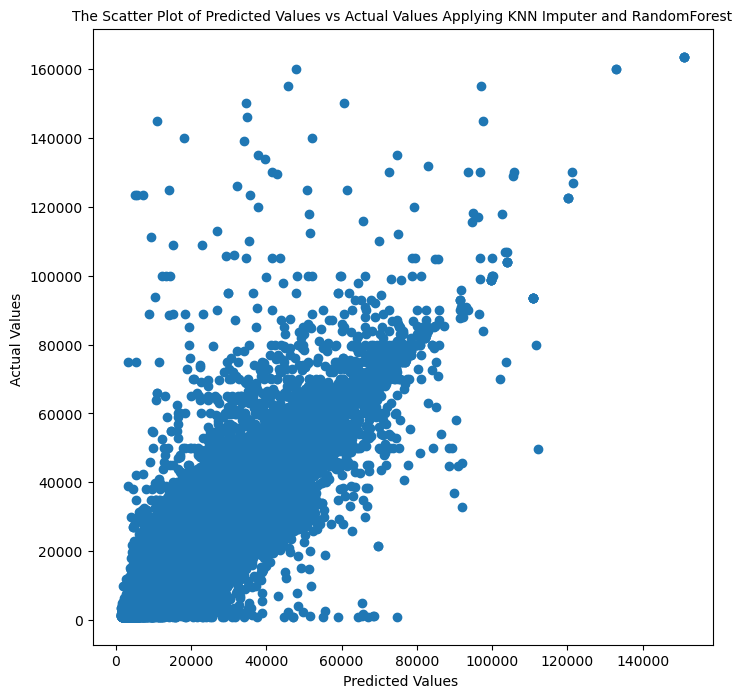

In [28]:
# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(rf_pipe_preds, y_test)
plt.xlabel("Predicted Values ")
plt.ylabel("Actual Values ")
plt.title('The Scatter Plot of Predicted Values vs Actual Values Applying KNN Imputer and RandomForest', size=10)
plt.show();

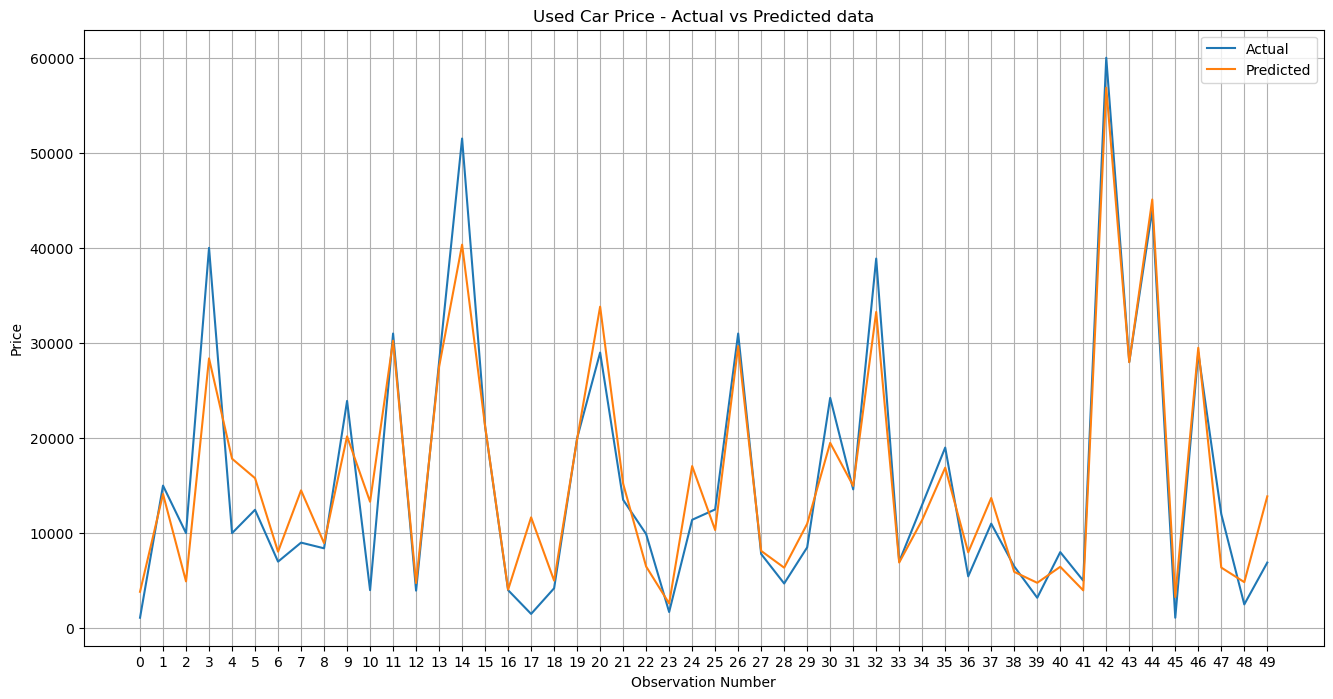

In [20]:
plot_actual_predict(rf_pipe)

### ExtraTreesRegressor

In [22]:
# ExtraTreesRegressor model add to pipeline with columntransformer

etr_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('etr', ExtraTreesRegressor(n_estimators=100, min_samples_leaf=3, min_samples_split=5))
    ]
)

In [23]:
etr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_ct',
                                                  Pipeline(steps=[('imp_knn',
                                                                   KNNImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1502ed590>),
                                                 ('cat_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('imp_knn',
                                                                   KNNImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1502ed5d0>)])),
                ('etr',
                 ExtraTreesRegressor(min_samples_leaf=3, min_samples_split=5))])

In [24]:
etr_pipe.score(X_train, y_train), etr_pipe.score(X_test,y_test)

(0.9405314950286391, 0.8404173873724133)

In [25]:
etr_pipe_preds = etr_pipe.predict(X_test)

In [26]:
scores.append(evaluation(X_train, y_train, X_test, y_test, etr_pipe_preds, etr_pipe))

train score: 0.9405314950286391
R2 (test score): 0.8404173873724133
RMSE: 5781.1034276887685


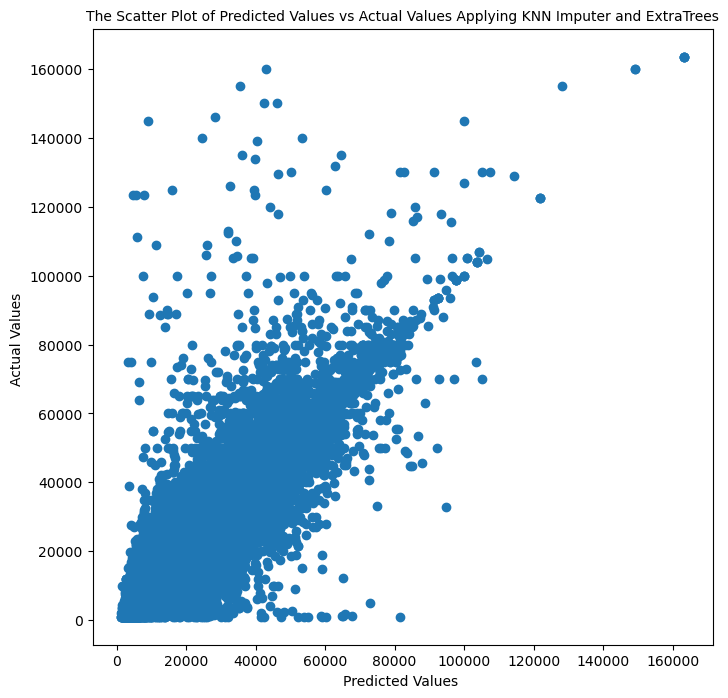

In [30]:
# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(etr_pipe_preds, y_test)
plt.xlabel("Predicted Values ")
plt.ylabel("Actual Values ")
plt.title('The Scatter Plot of Predicted Values vs Actual Values Applying KNN Imputer and ExtraTrees', size=10)
plt.show();

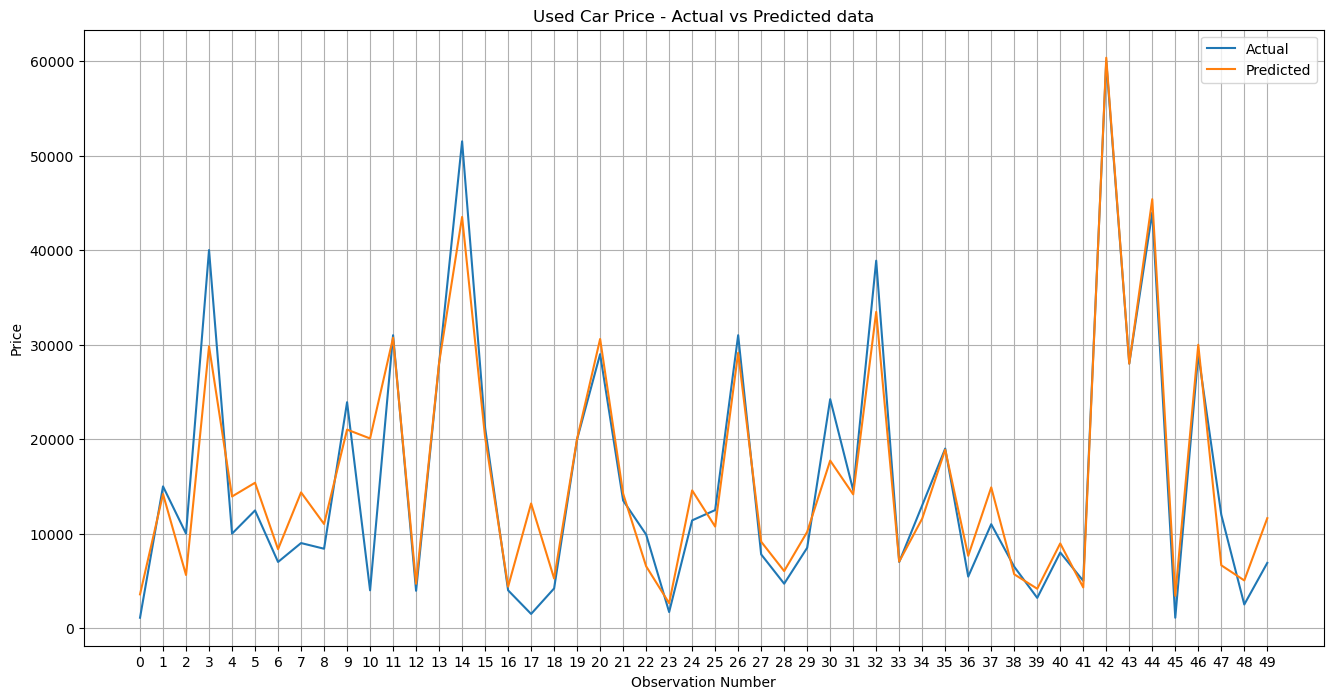

In [27]:
plot_actual_predict(etr_pipe)

In [30]:
# save model for streamlit

# with open('streamlit_app/etr_pipe.pkl', 'wb') as f:
#     pickle.dump(etr_pipe, f)

In [31]:
#save model for streamlit

# with open('streamlit_app/rf_pipe.pkl', 'wb') as f:
#     pickle.dump(rf_pipe, f)

### AdaBoost Regressor

In [31]:
# ExtraTreesRegressor model add to pipeline with columntransformer

adr_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('adr', AdaBoostRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5,min_samples_split=7)))
    ]
)

In [32]:
adr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_ct',
                                                  Pipeline(steps=[('imp_knn',
                                                                   KNNImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1502ed590>),
                                                 ('cat_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False)),
                                                                  ('imp_knn',
                                                                   KNNImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1502ed5d0>)])),
                ('adr',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                                                   min_samples_split=7)))])

In [33]:
adr_pipe.score(X_train, y_train), adr_pipe.score(X_test,y_test)

(0.9529415695770316, 0.8356169268900697)

In [34]:
adr_pipe_preds = adr_pipe.predict(X_test)

In [35]:
scores.append(evaluation(X_train, y_train, X_test, y_test, adr_pipe_preds, adr_pipe))

train score: 0.9529415695770316
R2 (test score): 0.8356169268900697
RMSE: 5867.410874494418


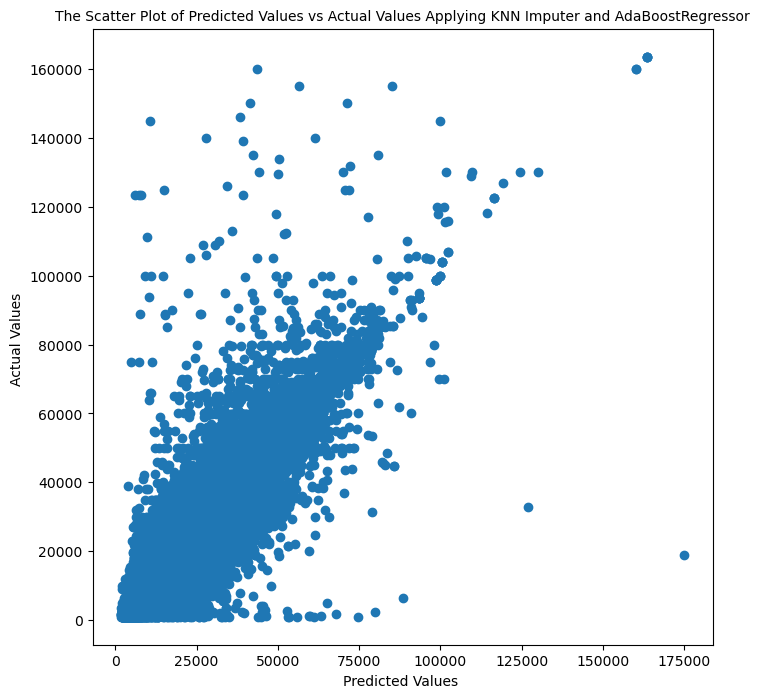

In [37]:
# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(adr_pipe_preds, y_test)
plt.xlabel("Predicted Values ")
plt.ylabel("Actual Values ")
plt.title('The Scatter Plot of Predicted Values vs Actual Values Applying KNN Imputer and AdaBoostRegressor', size=10)
plt.show();

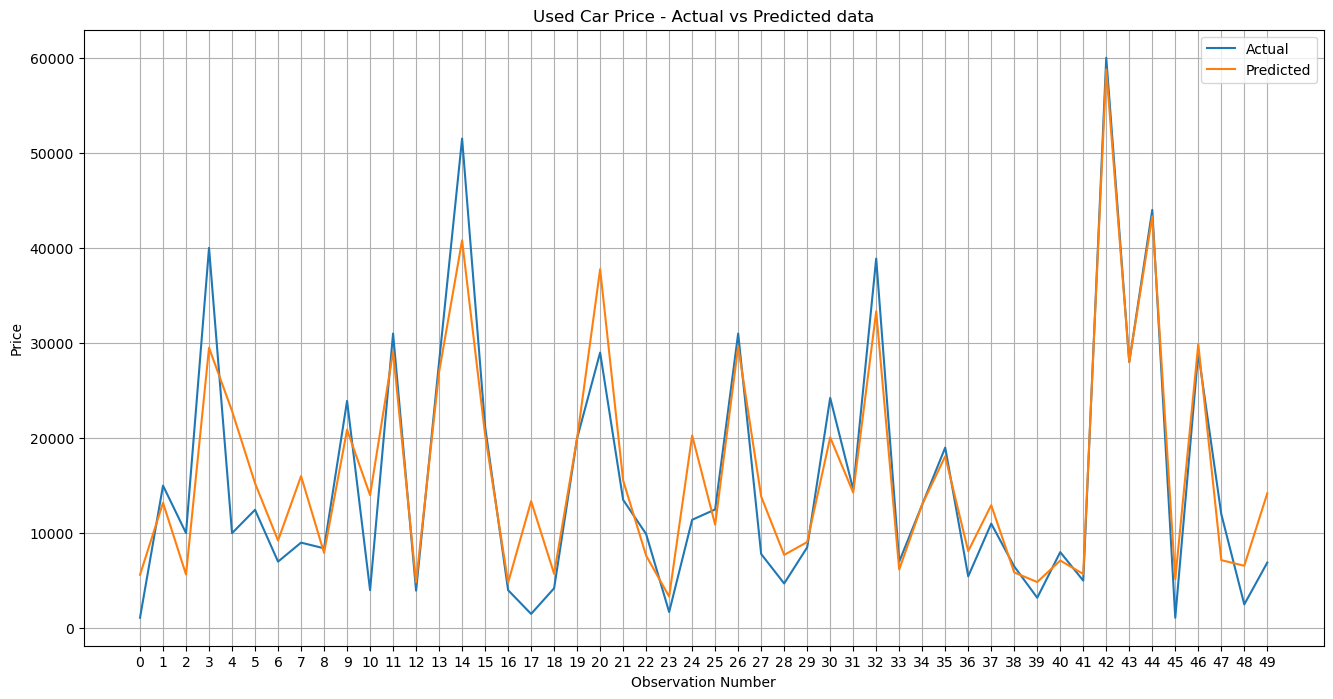

In [38]:
plot_actual_predict(adr_pipe)

In [39]:
pd.DataFrame(scores, index=['Random Forest Regressor', 
                            'Extra Trees Regresssor', 'AdaBoost Regressor'])

,train score,R2 (test score),RMSE
Random Forest Regressor,0.924610,0.836420,5853.052600
Extra Trees Regresssor,0.940531,0.840417,5781.103428
AdaBoost Regressor,0.952942,0.835617,5867.410874


## Conclusion

* ExtraTrees Regressor give the best performance with KNN inputer.
* Test 